# Purpose
The purpose of this notebook is to check some of the math that is used throughout to ensure (visually) that it is doing what I think it is doing.  We won't be checking the basic math operations, or other things that are easily checked in the unit tests.

First, we'll do our normal imports, and add the first two lines that form our initial test application:

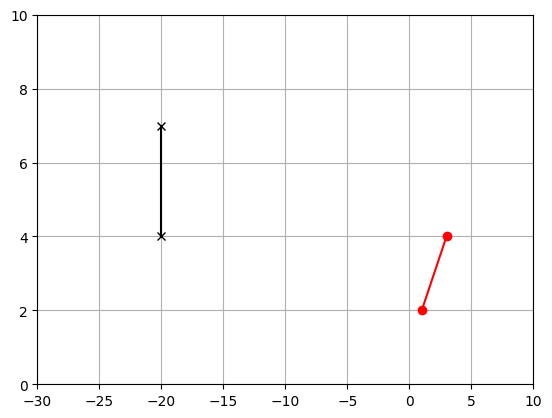

In [86]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np


class Point2D(object):
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y


class Line2D(object):
    def __init__(self, p1: Point2D, p2: Point2D):
        self.p1 = p1
        self.p2 = p2


def plot_line(line: Line2D, marker: str, color: str):
    plt.plot([line.p1.x, line.p2.x], [line.p1.y, line.p2.y], marker=marker, color=color)


line1 = Line2D(Point2D(1.0, 2.0), Point2D(3.0, 4.0))
line2 = Line2D(Point2D(-20.0, 4.0), Point2D(-20.0, 7.0))

ax = plt.gca()
plt.grid(True)
ax.set_xlim([-30, 10])
ax.set_ylim([0, 10])

plot_line(line1, marker="o", color="red")
plot_line(line2, marker="x", color="black")

plt.show()